# Coverage Analysis

This notebook analyzes the coverage data from CSV files in the '5xcoverage_csv_files-600-300-3' directory. We will plot coverage over time for all results, grouped by experiment number.

## Import Required Libraries

First, let's import the libraries we'll need for our analysis.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from glob import glob

# Set up the plotting style
plt.style.use('ggplot')
sns.set_theme()
plt.rcParams['figure.figsize'] = [12, 8]

## Load and Explore Data

In [2]:
# Define the base directory paths for all three tools
coverup_base_dir = 'data/coverup/scratch/experiment-results'
noplateau_base_dir = 'data/noplateau/scratch/experiment-results'
pynguin_base_dir = 'data/pynguin/scratch/experiment-results'

# Dictionary to map base directories to tool names
tool_dirs = {
    'coverup': coverup_base_dir,
    'noplateau': noplateau_base_dir,
    'pynguin': pynguin_base_dir
}

# Get all coverage CSV files from all three tools
csv_files = []
file_metadata = []

def get_module_name(file_path):
    # Read the actual module name from run-info.txt
    path_parts = file_path.split(os.sep)
    base_idx = path_parts.index('experiment-results')
    
    results_dir = os.path.join(*path_parts[:base_idx + 4])  # up to results-* folder
    run_info_path = os.path.join(results_dir, 'run-info.txt')
    
    module_name = path_parts[base_idx + 1]  # fallback to directory name
    if os.path.exists(run_info_path):
        try:
            with open(run_info_path, 'r') as f:
                for line in f:
                    if line.startswith('module-name:'):
                        module_name = line.split(':', 1)[1].strip()
                        break
        except Exception as e:
            print(f"Warning: Could not read module name from {run_info_path}: {e}")
    
    return module_name

# Process each tool's directory
for tool_name, base_dir in tool_dirs.items():
    print(f"\nProcessing {tool_name} from {base_dir}...")
    
    # Use glob to find all coverage_*.csv files in the nested structure
    pattern = os.path.join(base_dir, '*', '*', 'results-*', 'logs', 'coverage_*.csv')
    found_files = glob(pattern)
    
    for file_path in found_files:
        # Extract metadata from the path
        path_parts = file_path.split(os.sep)
        
        # Find the indices of the relevant parts
        try:
            base_idx = path_parts.index('experiment-results')

            module_name = get_module_name(file_path)
            module_run = path_parts[base_idx + 2]
            
            # Extract TOTAL_RUN from results-{TOTAL_RUN}
            results_part = path_parts[base_idx + 3]
            total_run = results_part.replace('results-', '')
            
            csv_files.append(file_path)
            file_metadata.append({
                'file_path': file_path,
                'tool': tool_name,
                'module_name': module_name,
                'module_run': module_run,
                'total_run': total_run,
                'filename': os.path.basename(file_path)
            })
        except (ValueError, IndexError) as e:
            print(f"Could not parse path structure for: {file_path}")

    print(f"Found {len([f for f in csv_files if tool_name in f])} CSV files for {tool_name}")

print(f"\nTotal: Found {len(csv_files)} CSV files across all tools")
print("Example files:", csv_files[:5] if len(csv_files) >= 5 else csv_files)

# Display metadata for first few files from each tool
if file_metadata:
    print("\nFile metadata examples by tool:")
    for tool_name in tool_dirs.keys():
        tool_files = [m for m in file_metadata if m['tool'] == tool_name]
        if tool_files:
            print(f"\n{tool_name.upper()}:")
            for i, metadata in enumerate(tool_files[:2]):
                print(f"  File {i+1}: {metadata}")


Processing coverup from data/coverup/scratch/experiment-results...
Found 809 CSV files for coverup

Processing noplateau from data/noplateau/scratch/experiment-results...
Found 659 CSV files for noplateau

Processing pynguin from data/pynguin/scratch/experiment-results...
Found 629 CSV files for pynguin

Total: Found 2097 CSV files across all tools
Example files: ['data/coverup/scratch/experiment-results/flutes/0/results-3/logs/coverage_0.csv', 'data/coverup/scratch/experiment-results/flutes/4/results-23/logs/coverage_4.csv', 'data/coverup/scratch/experiment-results/flutes/6/results-33/logs/coverage_6.csv', 'data/coverup/scratch/experiment-results/flutes/5/results-28/logs/coverage_5.csv', 'data/coverup/scratch/experiment-results/flutes/3/results-18/logs/coverage_3.csv']

File metadata examples by tool:

COVERUP:
  File 1: {'file_path': 'data/coverup/scratch/experiment-results/flutes/0/results-3/logs/coverage_0.csv', 'tool': 'coverup', 'module_name': 'flutes.math', 'module_run': '0', '

In [3]:
# Let's look at the structure of the first file to understand the data
if csv_files:
    df_example = pd.read_csv(csv_files[0])
    print(f"Shape of first file: {df_example.shape}")
    print("Columns:")
    print(df_example.columns.tolist())
    print("\nFirst few rows:")
    display(df_example.head())

Shape of first file: (1, 6)
Columns:
['iteration', 'finish_timestamp', 'finish_total_time_used', 'iteration_type', 'best_coverage', 'coverage']

First few rows:


,iteration,finish_timestamp,finish_total_time_used,iteration_type,best_coverage,coverage
0,1,17,15,coverup,100,100


## Process All Data Files

Now we'll load all the CSV files and combine them into a single DataFrame, extracting the experiment number and run information from the file names.

In [4]:
def extract_info_from_file_metadata(file_path):
    """Extract experiment info from file metadata"""
    # Find the corresponding metadata for this file
    for metadata in file_metadata:
        if metadata['file_path'] == file_path:
            total_run_num = int(metadata['total_run'])
            module_run_num = int(metadata['module_run'])
            module = metadata['module_name']
            tool = metadata['tool']
            return total_run_num, module_run_num, module, tool
    return None, None, None, None

# Create an empty list to store all dataframes
all_dfs = []

# Process each CSV file
for file in csv_files:
    try:
        # Extract information from filename
        total_run_num, module_run_num, module, tool = extract_info_from_file_metadata(file)
        
        if total_run_num is not None:
            # Read the CSV file
            df = pd.read_csv(file)
            
            # Add metadata columns
            df['total_run_num'] = total_run_num
            df['module_run_num'] = module_run_num
            df['module'] = module
            df['tool'] = tool
            
            # Append to the list of dataframes
            all_dfs.append(df)
    except Exception as e:
        print(f"Error processing {file}: {e}")

# Combine all dataframes
if all_dfs:
    combined_df = pd.concat(all_dfs, ignore_index=True)
    print(f"Combined data shape: {combined_df.shape}")
    print(f"Number of tools: {combined_df['tool'].nunique()}")
    print(f"Tools: {combined_df['tool'].unique()}")
    print(f"Number of modules: {combined_df['module'].nunique()}")
    print(f"Modules: {combined_df['module'].unique()}")
    display(combined_df.head())
else:
    print("No data files were successfully processed")

Combined data shape: (63579, 10)
Number of tools: 3
Tools: ['coverup' 'noplateau' 'pynguin']
Number of modules: 23
Modules: ['flutes.math' 'pytutils.env' 'pytutils.excs' 'flutils.pathutils'
 'flutils.decorators' 'isort.io' 'semantic_release.dist'
 'semantic_release.ci_checks' 'flake8.main.debug'
 'flake8.options.aggregator' 'flake8.statistics' 'docstring_parser.google'
 'docstring_parser.numpydoc' 'httpie.utils'
 'httpie.output.formatters.json' 'dataclasses_json.core'
 'dataclasses_json.cfg' 'dataclasses_json.undefined'
 'blib2to3.pgen2.literals' 'py_backwards.conf' 'pypara.commons.others'
 'pymonet.semigroups' 'pypara.accounting.journaling']


,iteration,finish_timestamp,finish_total_time_used,iteration_type,best_coverage,coverage,total_run_num,module_run_num,module,tool
0,1,17,15,coverup,100,100,3,0,flutes.math,coverup
1,1,25,24,coverup,100,100,23,4,flutes.math,coverup
2,1,16,14,coverup,100,100,33,6,flutes.math,coverup
3,1,16,14,coverup,100,100,28,5,flutes.math,coverup
4,1,25,24,coverup,100,100,18,3,flutes.math,coverup


In [5]:
# Find modules that exist for all tools
tools_set = set(combined_df['tool'].unique())
modules_per_tool = combined_df.groupby('tool')['module'].unique()
modules_all_tools = set.intersection(*(set(mods) for mods in modules_per_tool))

all_modules = set(combined_df['module'].unique())
excluded_modules = all_modules - modules_all_tools

print(f"Modules present in all tools: {len(modules_all_tools)}")
print(sorted(modules_all_tools))
print(f"\nModules excluded (not present in all tools): {len(excluded_modules)}")
print(sorted(excluded_modules))

# Filter combined_df to only keep these modules
combined_df = combined_df[combined_df['module'].isin(modules_all_tools)].reset_index(drop=True)

Modules present in all tools: 20
['dataclasses_json.core', 'dataclasses_json.undefined', 'docstring_parser.google', 'docstring_parser.numpydoc', 'flake8.main.debug', 'flake8.options.aggregator', 'flake8.statistics', 'flutes.math', 'flutils.decorators', 'flutils.pathutils', 'httpie.output.formatters.json', 'httpie.utils', 'isort.io', 'py_backwards.conf', 'pymonet.semigroups', 'pypara.commons.others', 'pytutils.env', 'pytutils.excs', 'semantic_release.ci_checks', 'semantic_release.dist']

Modules excluded (not present in all tools): 3
['blib2to3.pgen2.literals', 'dataclasses_json.cfg', 'pypara.accounting.journaling']


In [6]:
# For each module-tool combination, extend runs that ended early with a flat line to the module's max iteration

# 1. Find the highest iteration number for each module-tool combination
module_tool_max_iter = combined_df.groupby(['module', 'tool'])['iteration'].max().to_dict()

# 2. Prepare a list to collect new rows
rows_to_add = []

# 3. For each run (module_run_num) in each module-tool combination, check if it ended early
for (module, tool, module_run_num), group in combined_df.groupby(['module', 'tool', 'module_run_num']):
    run_max_iter = group['iteration'].max()
    module_tool_iter = module_tool_max_iter[(module, tool)]
    if run_max_iter < module_tool_iter:
        # Get the row with the highest iteration for this run
        last_row = group[group['iteration'] == run_max_iter].iloc[-1].copy()
        # For all missing iterations, clone and modify as requested
        for missing_iter in range(run_max_iter + 1, module_tool_iter + 1):
            new_row = last_row.copy()
            new_row['iteration'] = missing_iter
            rows_to_add.append(new_row)

# 4. Add the new rows to the dataframe
if rows_to_add:
    combined_df = pd.concat([combined_df, pd.DataFrame(rows_to_add)], ignore_index=True)

## Group Data by Experiment

Now, let's calculate statistics for each experiment - median, mean, min, and max coverage over time.

In [7]:
# First, let's ensure we have the right columns for our analysis
if 'combined_df' in locals():
    
    coverage_column = 'best_coverage'
    time_column = 'iteration'
    
    print(f"\nUsing '{coverage_column}' as the coverage measure and '{time_column}' as the time measure")

    # Group by module, tool, and time, then calculate statistics
    grouped = combined_df.groupby(['module', 'tool', time_column])[coverage_column].agg(['median','mean', 'min', 'max']).reset_index()
    
    print("\nCalculated statistics by module, tool, and time:")
    display(grouped.head(10))
    
    # Show summary by tool
    print("\nSummary by tool:")
    for tool in grouped['tool'].unique():
        tool_data = grouped[grouped['tool'] == tool]
        print(f"{tool}: {len(tool_data)} data points across {tool_data['module'].nunique()} modules")
else:
    print("No combined dataframe available for analysis")


modules = sorted(grouped['module'].unique())
tools = sorted(grouped['tool'].unique())


Using 'best_coverage' as the coverage measure and 'iteration' as the time measure

Calculated statistics by module, tool, and time:


,module,tool,iteration,median,mean,min,max
0,dataclasses_json.core,coverup,1,71.0,66.833333,39,81
1,dataclasses_json.core,coverup,2,72.0,67.2,39,81
2,dataclasses_json.core,coverup,3,72.5,67.433333,39,81
3,dataclasses_json.core,coverup,4,72.5,68.266667,39,83
4,dataclasses_json.core,coverup,5,73.0,68.466667,39,83
5,dataclasses_json.core,coverup,6,73.0,68.466667,39,83
6,dataclasses_json.core,coverup,7,75.0,70.766667,39,83
7,dataclasses_json.core,coverup,8,76.0,71.3,39,83
8,dataclasses_json.core,coverup,9,76.0,71.3,39,83
9,dataclasses_json.core,coverup,10,76.0,73.0,39,83



Summary by tool:
coverup: 444 data points across 20 modules
noplateau: 518 data points across 20 modules
pynguin: 1604 data points across 20 modules


In [8]:
# Check if coverage is ever higher than best_coverage (which shouldn't happen)
coverage_issues = combined_df[combined_df['coverage'] > combined_df['best_coverage']]
if len(coverage_issues) > 0:
    print(f"\nFound {len(coverage_issues)} cases where 'coverage' > 'best_coverage' (unexpected):")
    display(coverage_issues[['module', 'iteration', 'coverage', 'best_coverage']].head())
else:
    print("\nNo cases found where 'coverage' > 'best_coverage' (as expected)")



No cases found where 'coverage' > 'best_coverage' (as expected)


In [9]:
# Analyze if mean, min, or max ever decrease within each module-tool combination as iterations progress
decreasing_stats = []

for (module, tool) in grouped[['module', 'tool']].drop_duplicates().values:
    module_tool_data = grouped[(grouped['module'] == module) & (grouped['tool'] == tool)].sort_values('iteration')
    
    # Check for decreasing statistics
    for i in range(1, len(module_tool_data)):
        current_row = module_tool_data.iloc[i]
        previous_row = module_tool_data.iloc[i-1]
        
        # Check if median decreased
        if current_row['median'] < previous_row['median']:
            decreasing_stats.append({
                'module': module,
                'tool': tool,
                'iteration': current_row['iteration'],
                'stat_type': 'median',
                'previous_value': previous_row['median'],
                'current_value': current_row['median'],
                'decrease': previous_row['median'] - current_row['median']
            })
        
        # Check if mean decreased
        if current_row['mean'] < previous_row['mean']:
            decreasing_stats.append({
                'module': module,
                'tool': tool,
                'iteration': current_row['iteration'],
                'stat_type': 'mean',
                'previous_value': previous_row['mean'],
                'current_value': current_row['mean'],
                'decrease': previous_row['mean'] - current_row['mean']
            })
        
        # Check if min decreased
        if current_row['min'] < previous_row['min']:
            decreasing_stats.append({
                'module': module,
                'tool': tool,
                'iteration': current_row['iteration'],
                'stat_type': 'min',
                'previous_value': previous_row['min'],
                'current_value': current_row['min'],
                'decrease': previous_row['min'] - current_row['min']
            })
        
        # Check if max decreased
        if current_row['max'] < previous_row['max']:
            decreasing_stats.append({
                'module': module,
                'tool': tool,
                'iteration': current_row['iteration'],
                'stat_type': 'max',
                'previous_value': previous_row['max'],
                'current_value': current_row['max'],
                'decrease': previous_row['max'] - current_row['max']
            })

if decreasing_stats:
    decreasing_df = pd.DataFrame(decreasing_stats)
    print(f"Found {len(decreasing_stats)} instances where statistics decreased:")
    display(decreasing_df)
    
    # Summary by statistic type
    print("\nSummary by statistic type:")
    print(decreasing_df['stat_type'].value_counts())
    
    # Summary by module
    print("\nSummary by module:")
    print(decreasing_df['module'].value_counts())
    
    # Summary by tool
    print("\nSummary by tool:")
    print(decreasing_df['tool'].value_counts())
    
    # Largest decreases
    print("\nLargest decreases:")
    print(decreasing_df.nlargest(10, 'decrease')[['module', 'tool', 'iteration', 'stat_type', 'decrease']])
    
else:
    print("No instances found where median, mean, min, or max decreased within any module-tool combination.")


No instances found where median, mean, min, or max decreased within any module-tool combination.


## Plot Coverage Over Time

Now, we'll create plots to visualize the coverage over time for each experiment, showing the mean line and the min-max range as a shaded area.

In [10]:
# Define colors for consistent plotting
tool_colors = {'coverup': 'blue', 'noplateau': 'red', 'pynguin': 'green'}

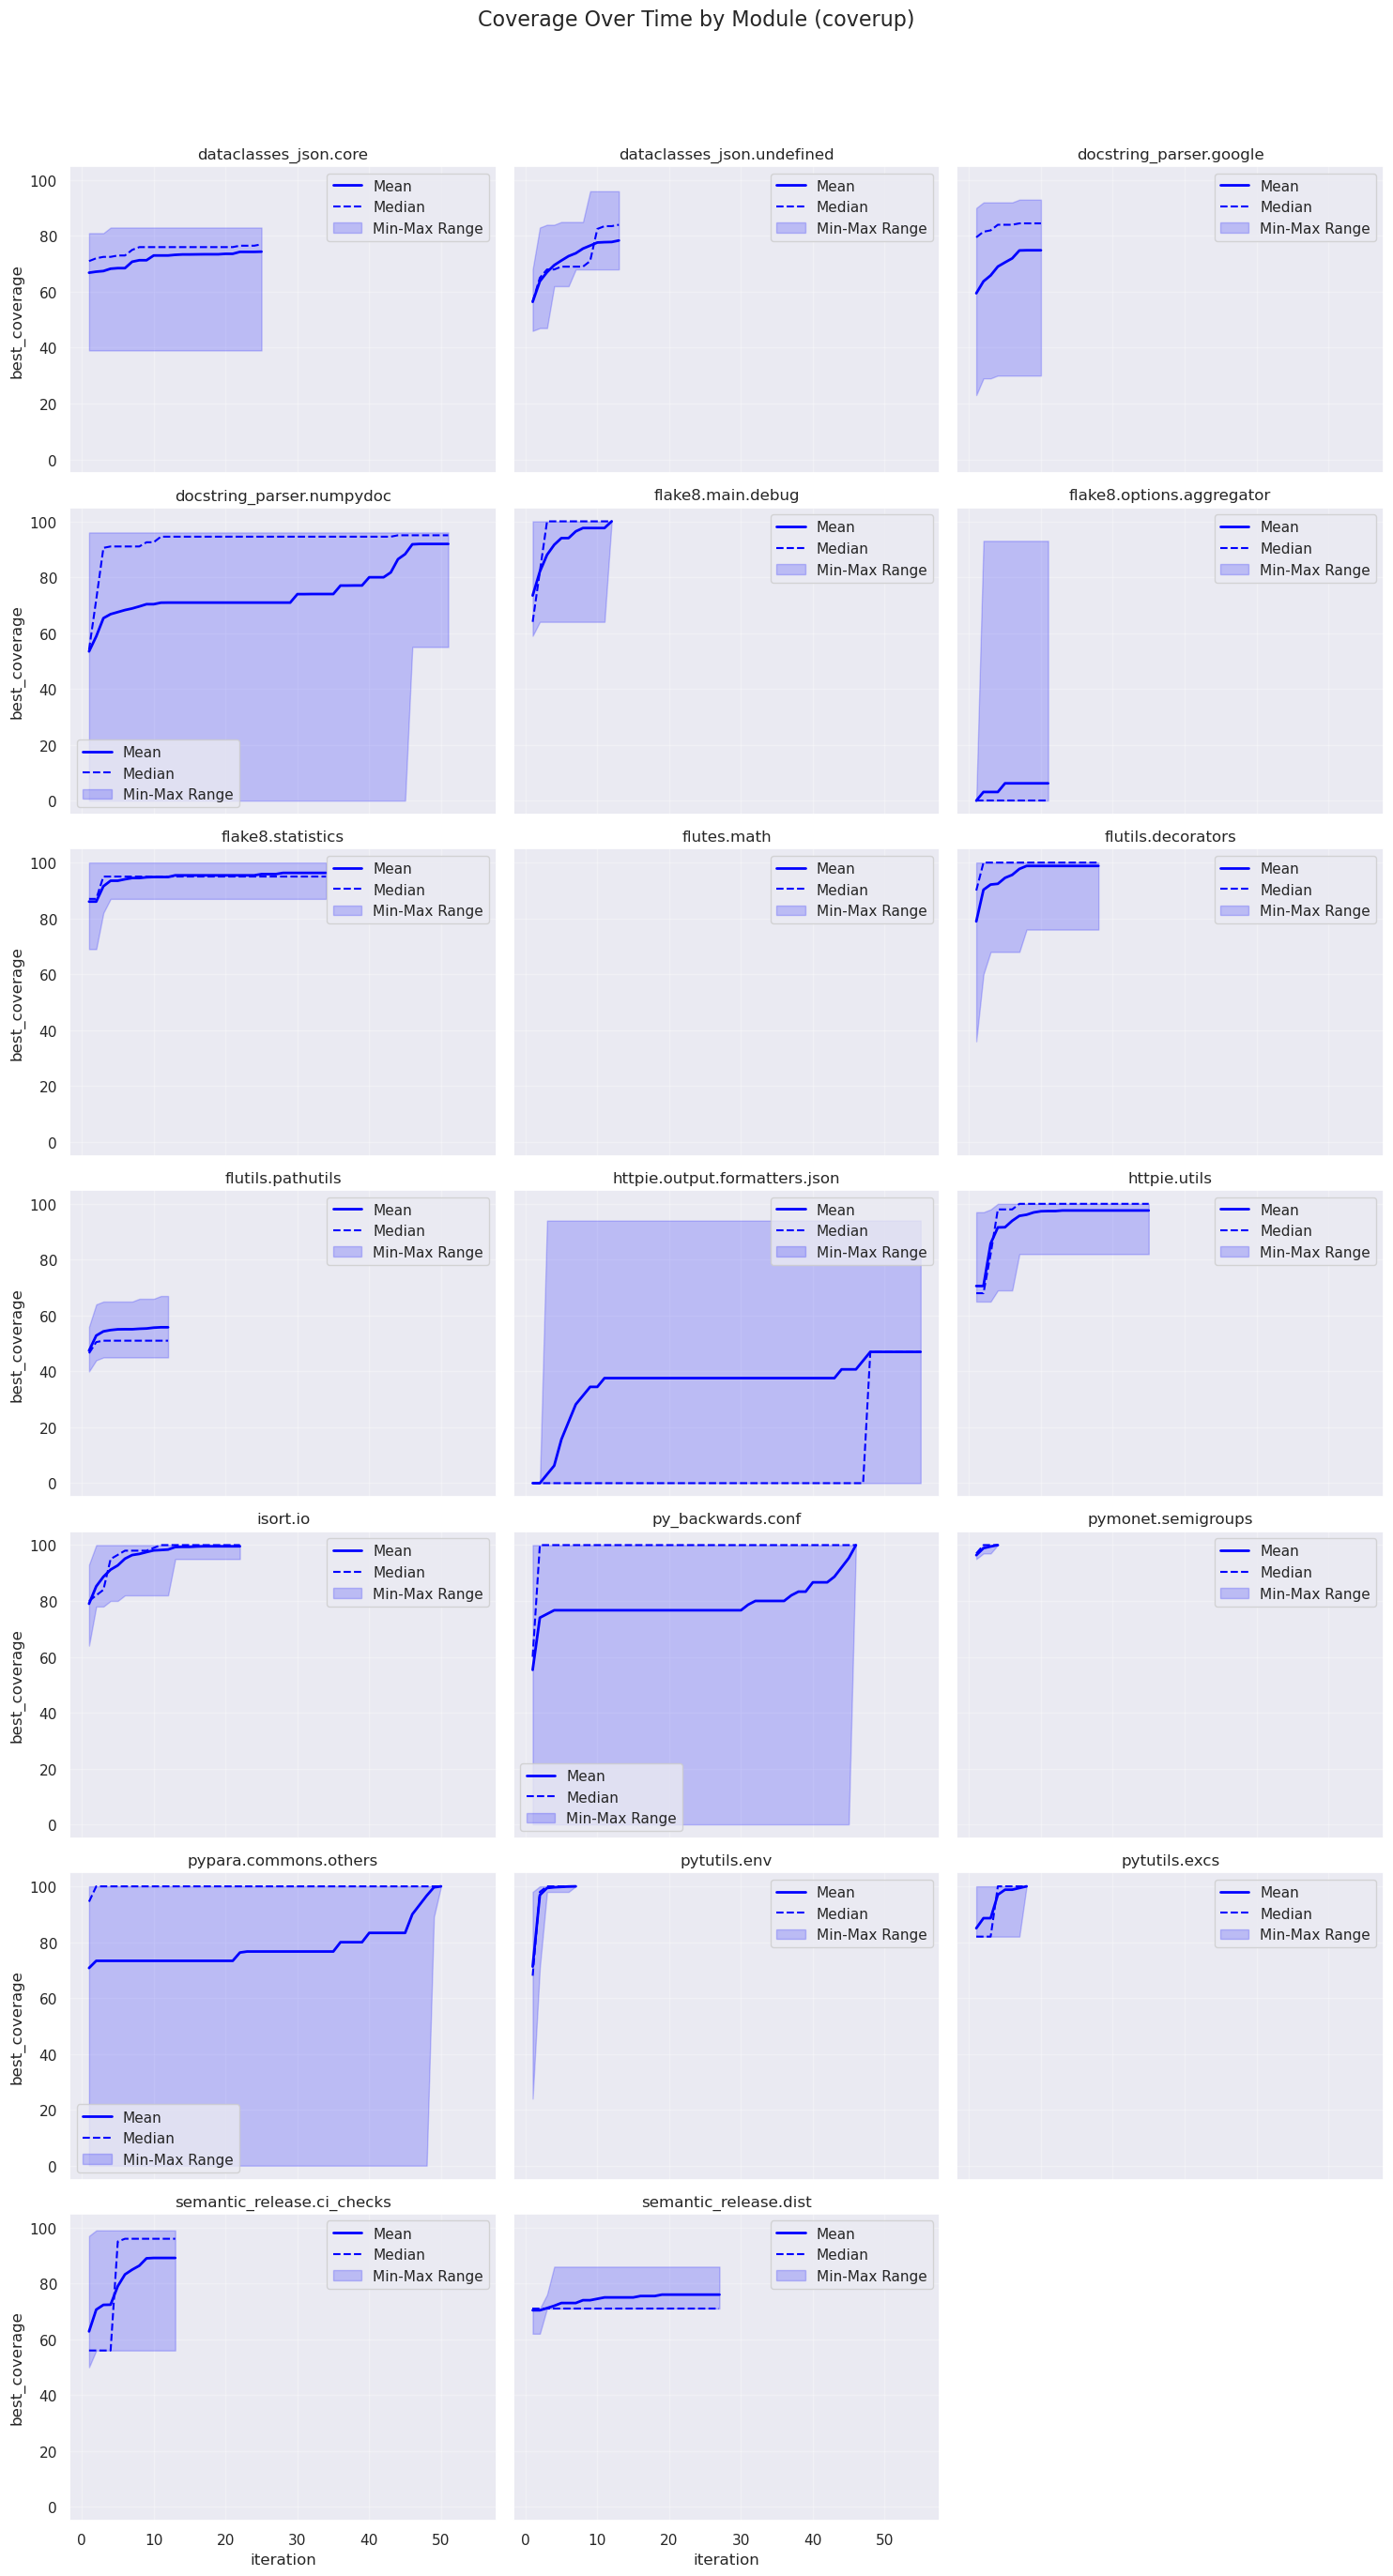

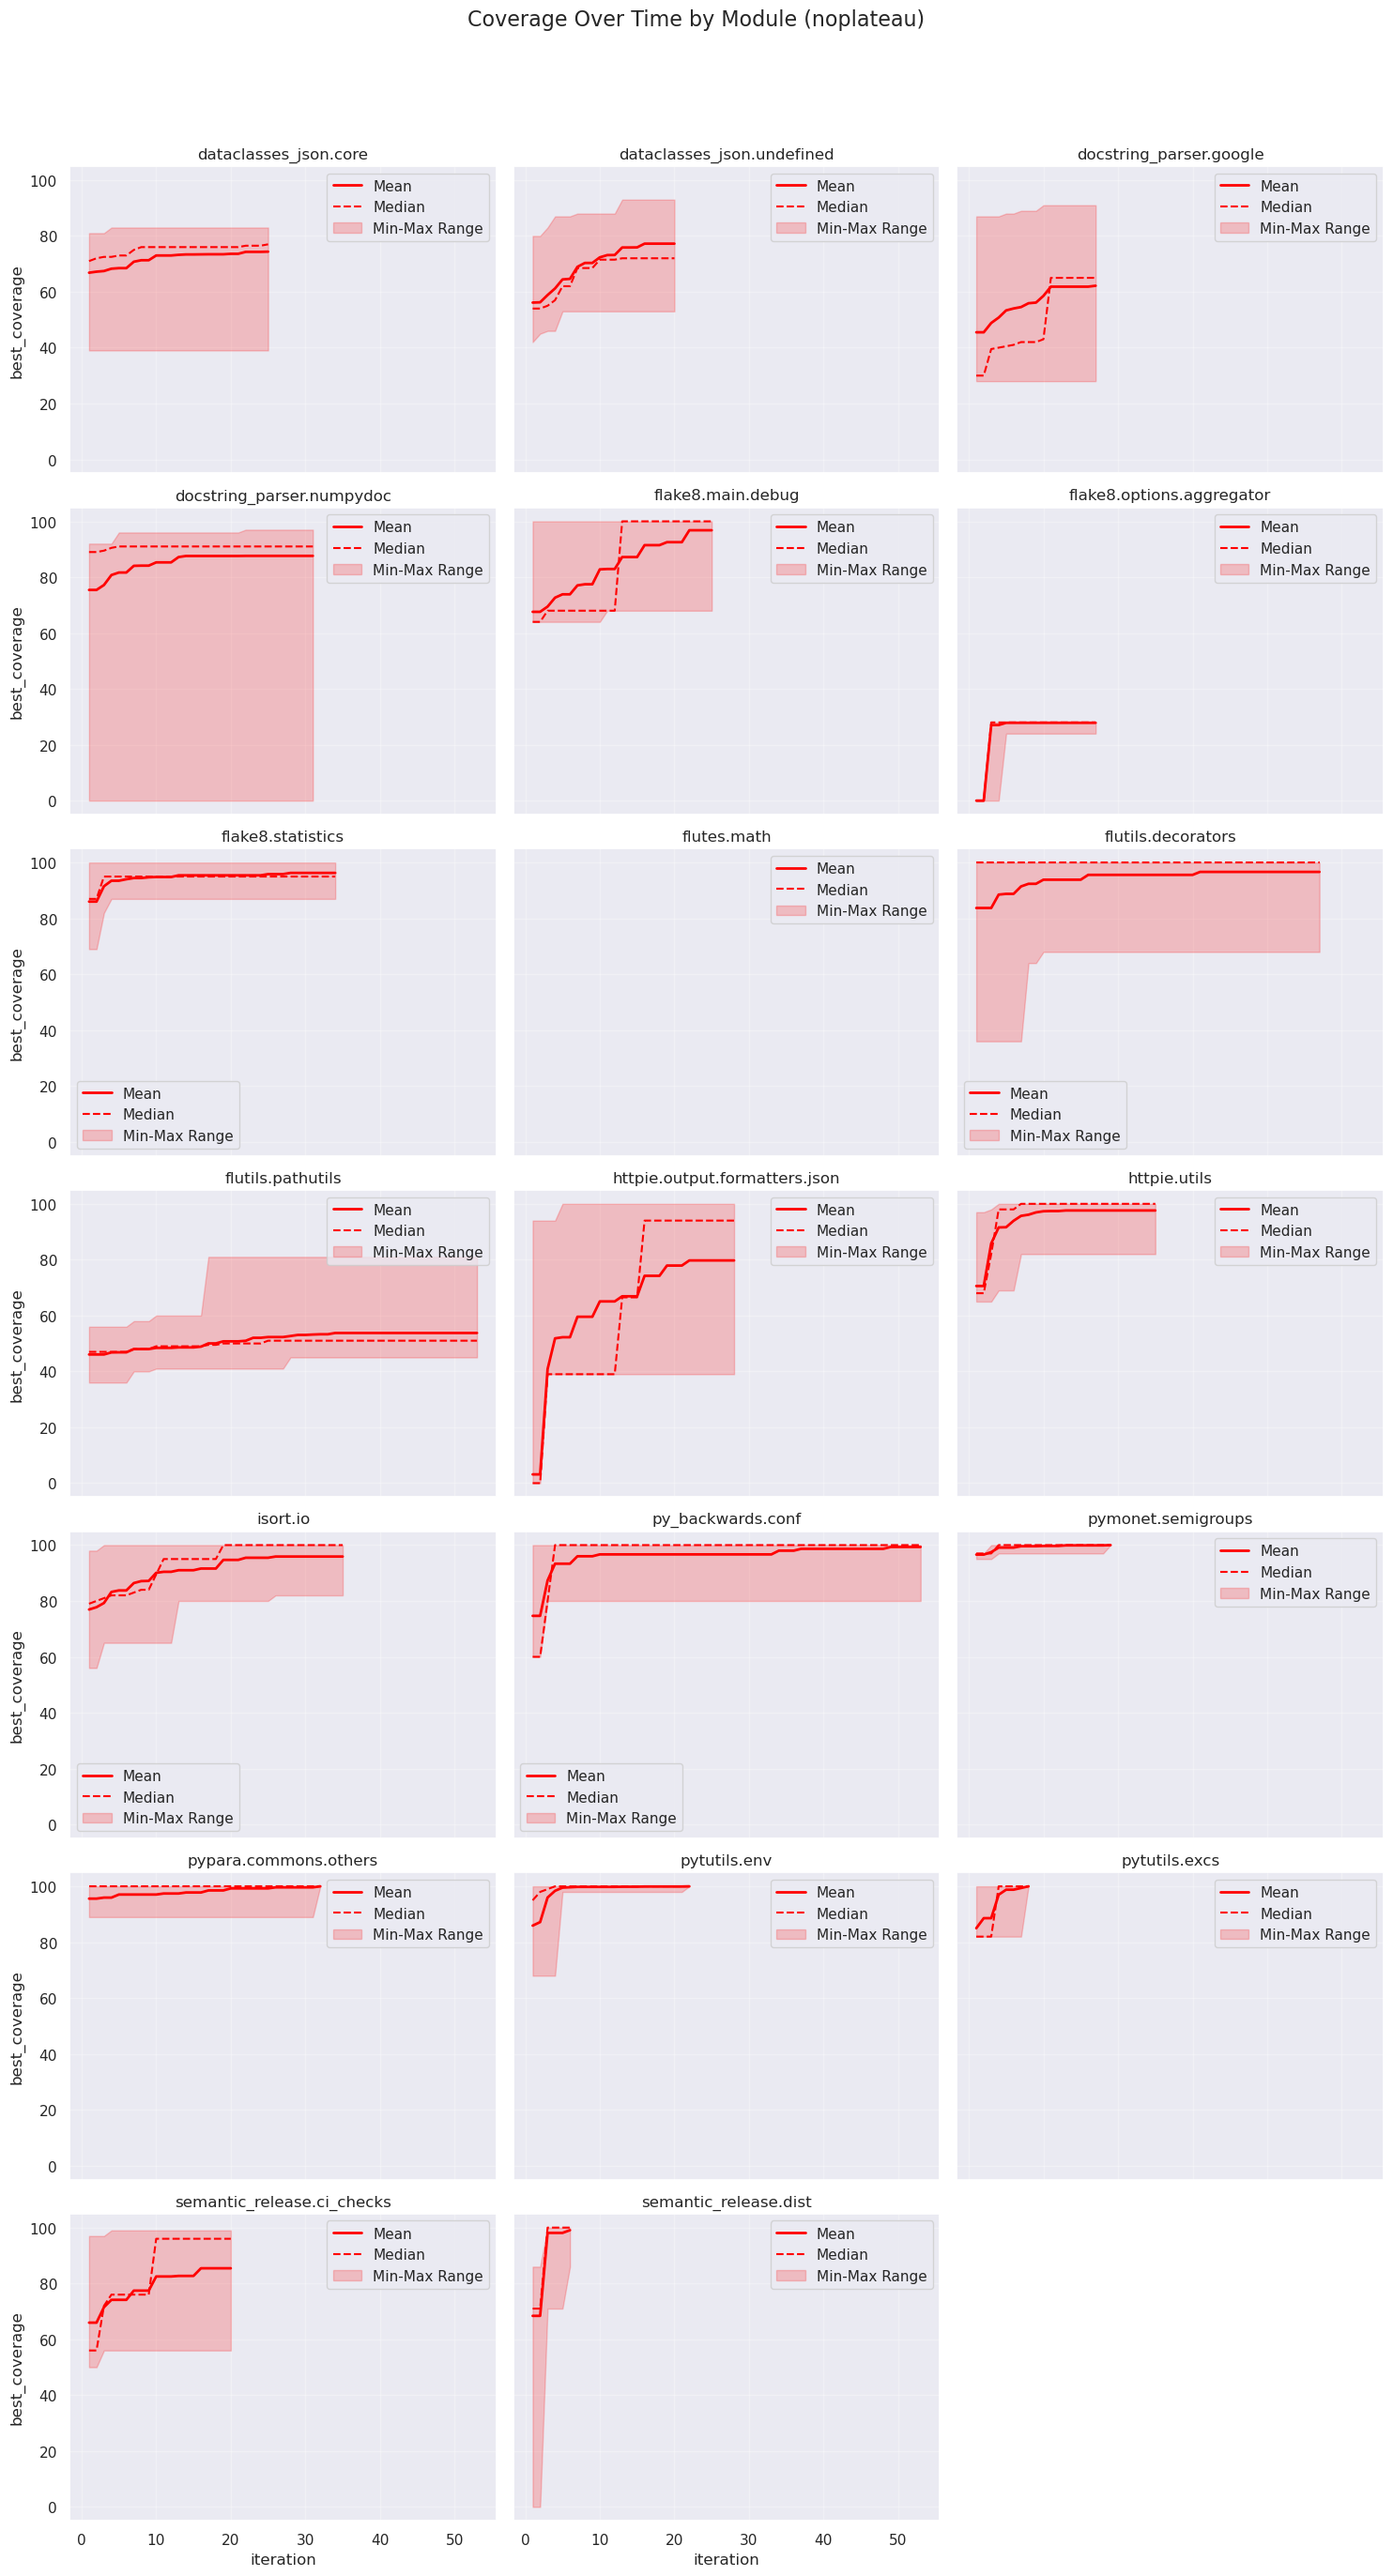

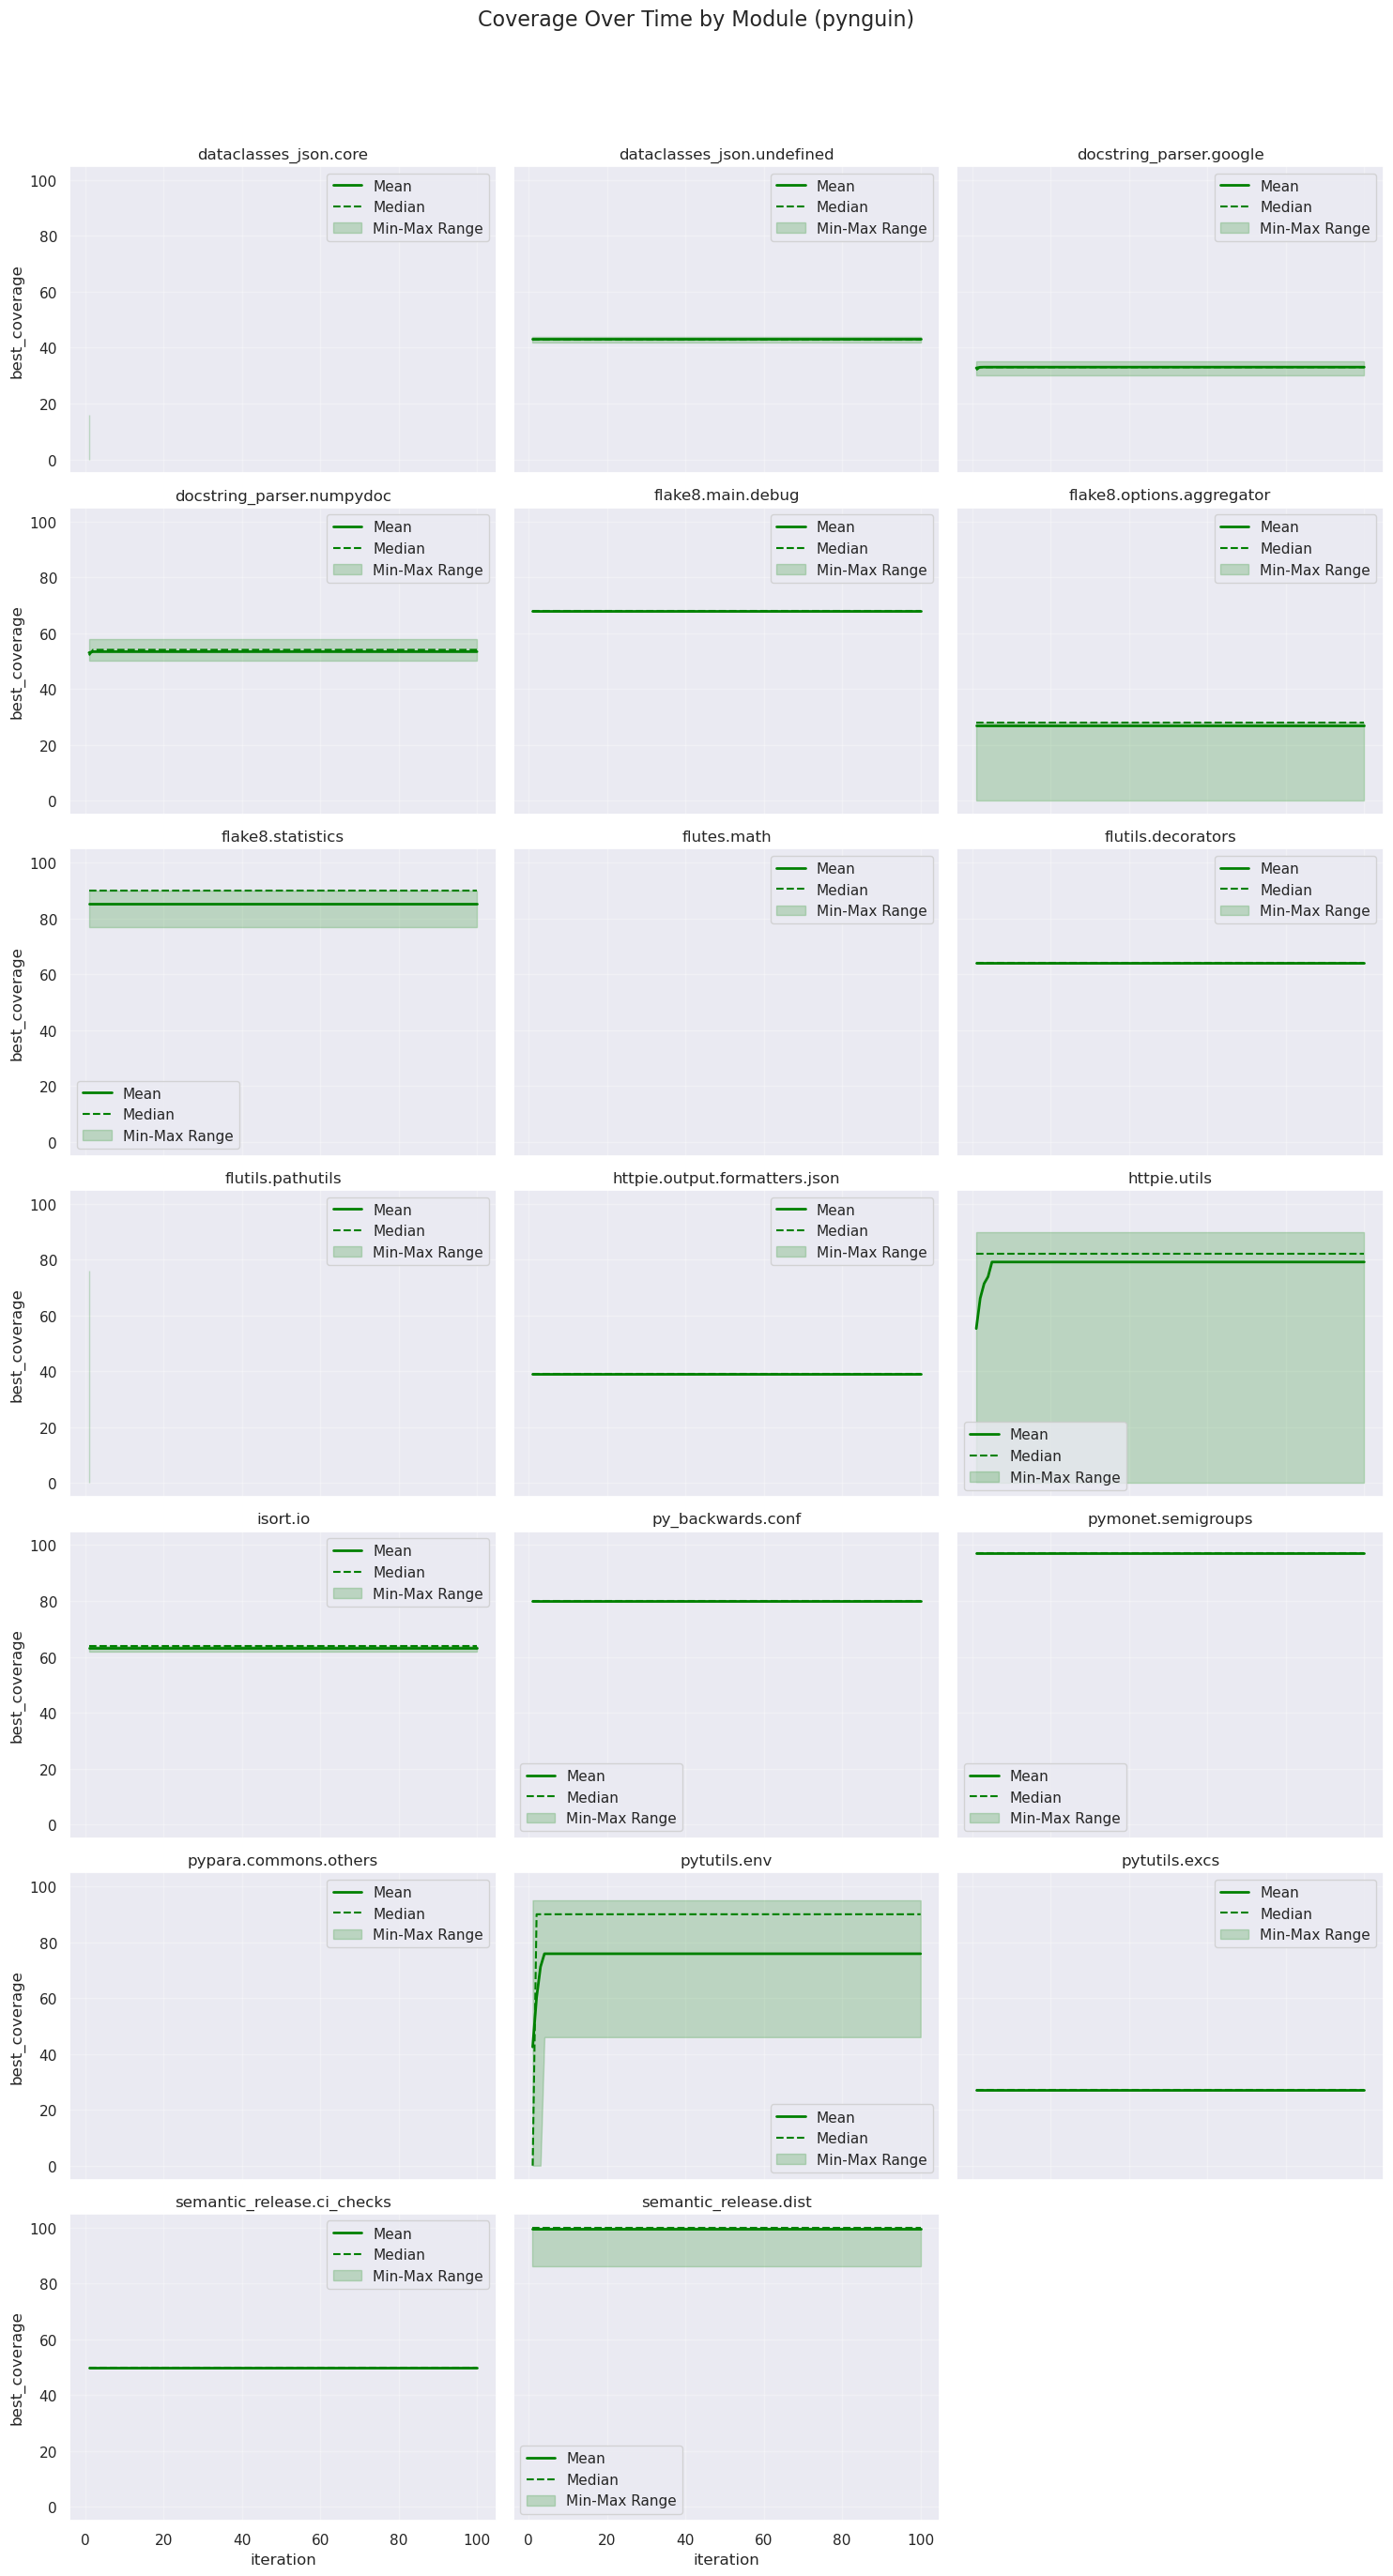

In [11]:
# Plot coverage over time by module for each tool, saving an individual image for each tool

for tool in tools:
    tool_data = grouped[grouped['tool'] == tool]
    modules = sorted(tool_data['module'].unique())
    n_modules = len(modules)
    n_cols = min(3, n_modules)
    n_rows = (n_modules + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4*n_rows), sharex=True, sharey=True)
    axes = axes.flatten() if n_rows * n_cols > 1 else [axes]

    for i, module in enumerate(modules):
        ax = axes[i]
        module_data = tool_data[tool_data['module'] == module].copy()

        # Convert columns to numeric for plotting
        module_data[time_column] = pd.to_numeric(module_data[time_column], errors='coerce')
        module_data['mean'] = pd.to_numeric(module_data['mean'], errors='coerce')
        module_data['median'] = pd.to_numeric(module_data['median'], errors='coerce')
        module_data['min'] = pd.to_numeric(module_data['min'], errors='coerce')
        module_data['max'] = pd.to_numeric(module_data['max'], errors='coerce')

        color = tool_colors.get(tool, 'gray')

        # Plot mean line
        ax.plot(module_data[time_column], module_data['mean'],
                color=color,
                linewidth=2,
                label='Mean')

        # Plot median line
        ax.plot(module_data[time_column], module_data['median'],
                color=color,
                linestyle='--',
                linewidth=1.5,
                label='Median')

        # Add shaded area for min-max range
        ax.fill_between(module_data[time_column],
                        module_data['min'],
                        module_data['max'],
                        color=color,
                        alpha=0.2,
                        label='Min-Max Range')

        ax.set_title(f'{module}')
        ax.grid(True, alpha=0.3)
        ax.legend()

        if i % n_cols == 0:
            ax.set_ylabel(coverage_column)
        if i >= (n_rows - 1) * n_cols:
            ax.set_xlabel(time_column)

    # Hide unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)

    plt.suptitle(f'Coverage Over Time by Module ({tool})', fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)

    os.makedirs('figures', exist_ok=True)
    plt.savefig(f'figures/coverage_over_time_by_module_{tool}.png', dpi=300, bbox_inches='tight')
    plt.show()


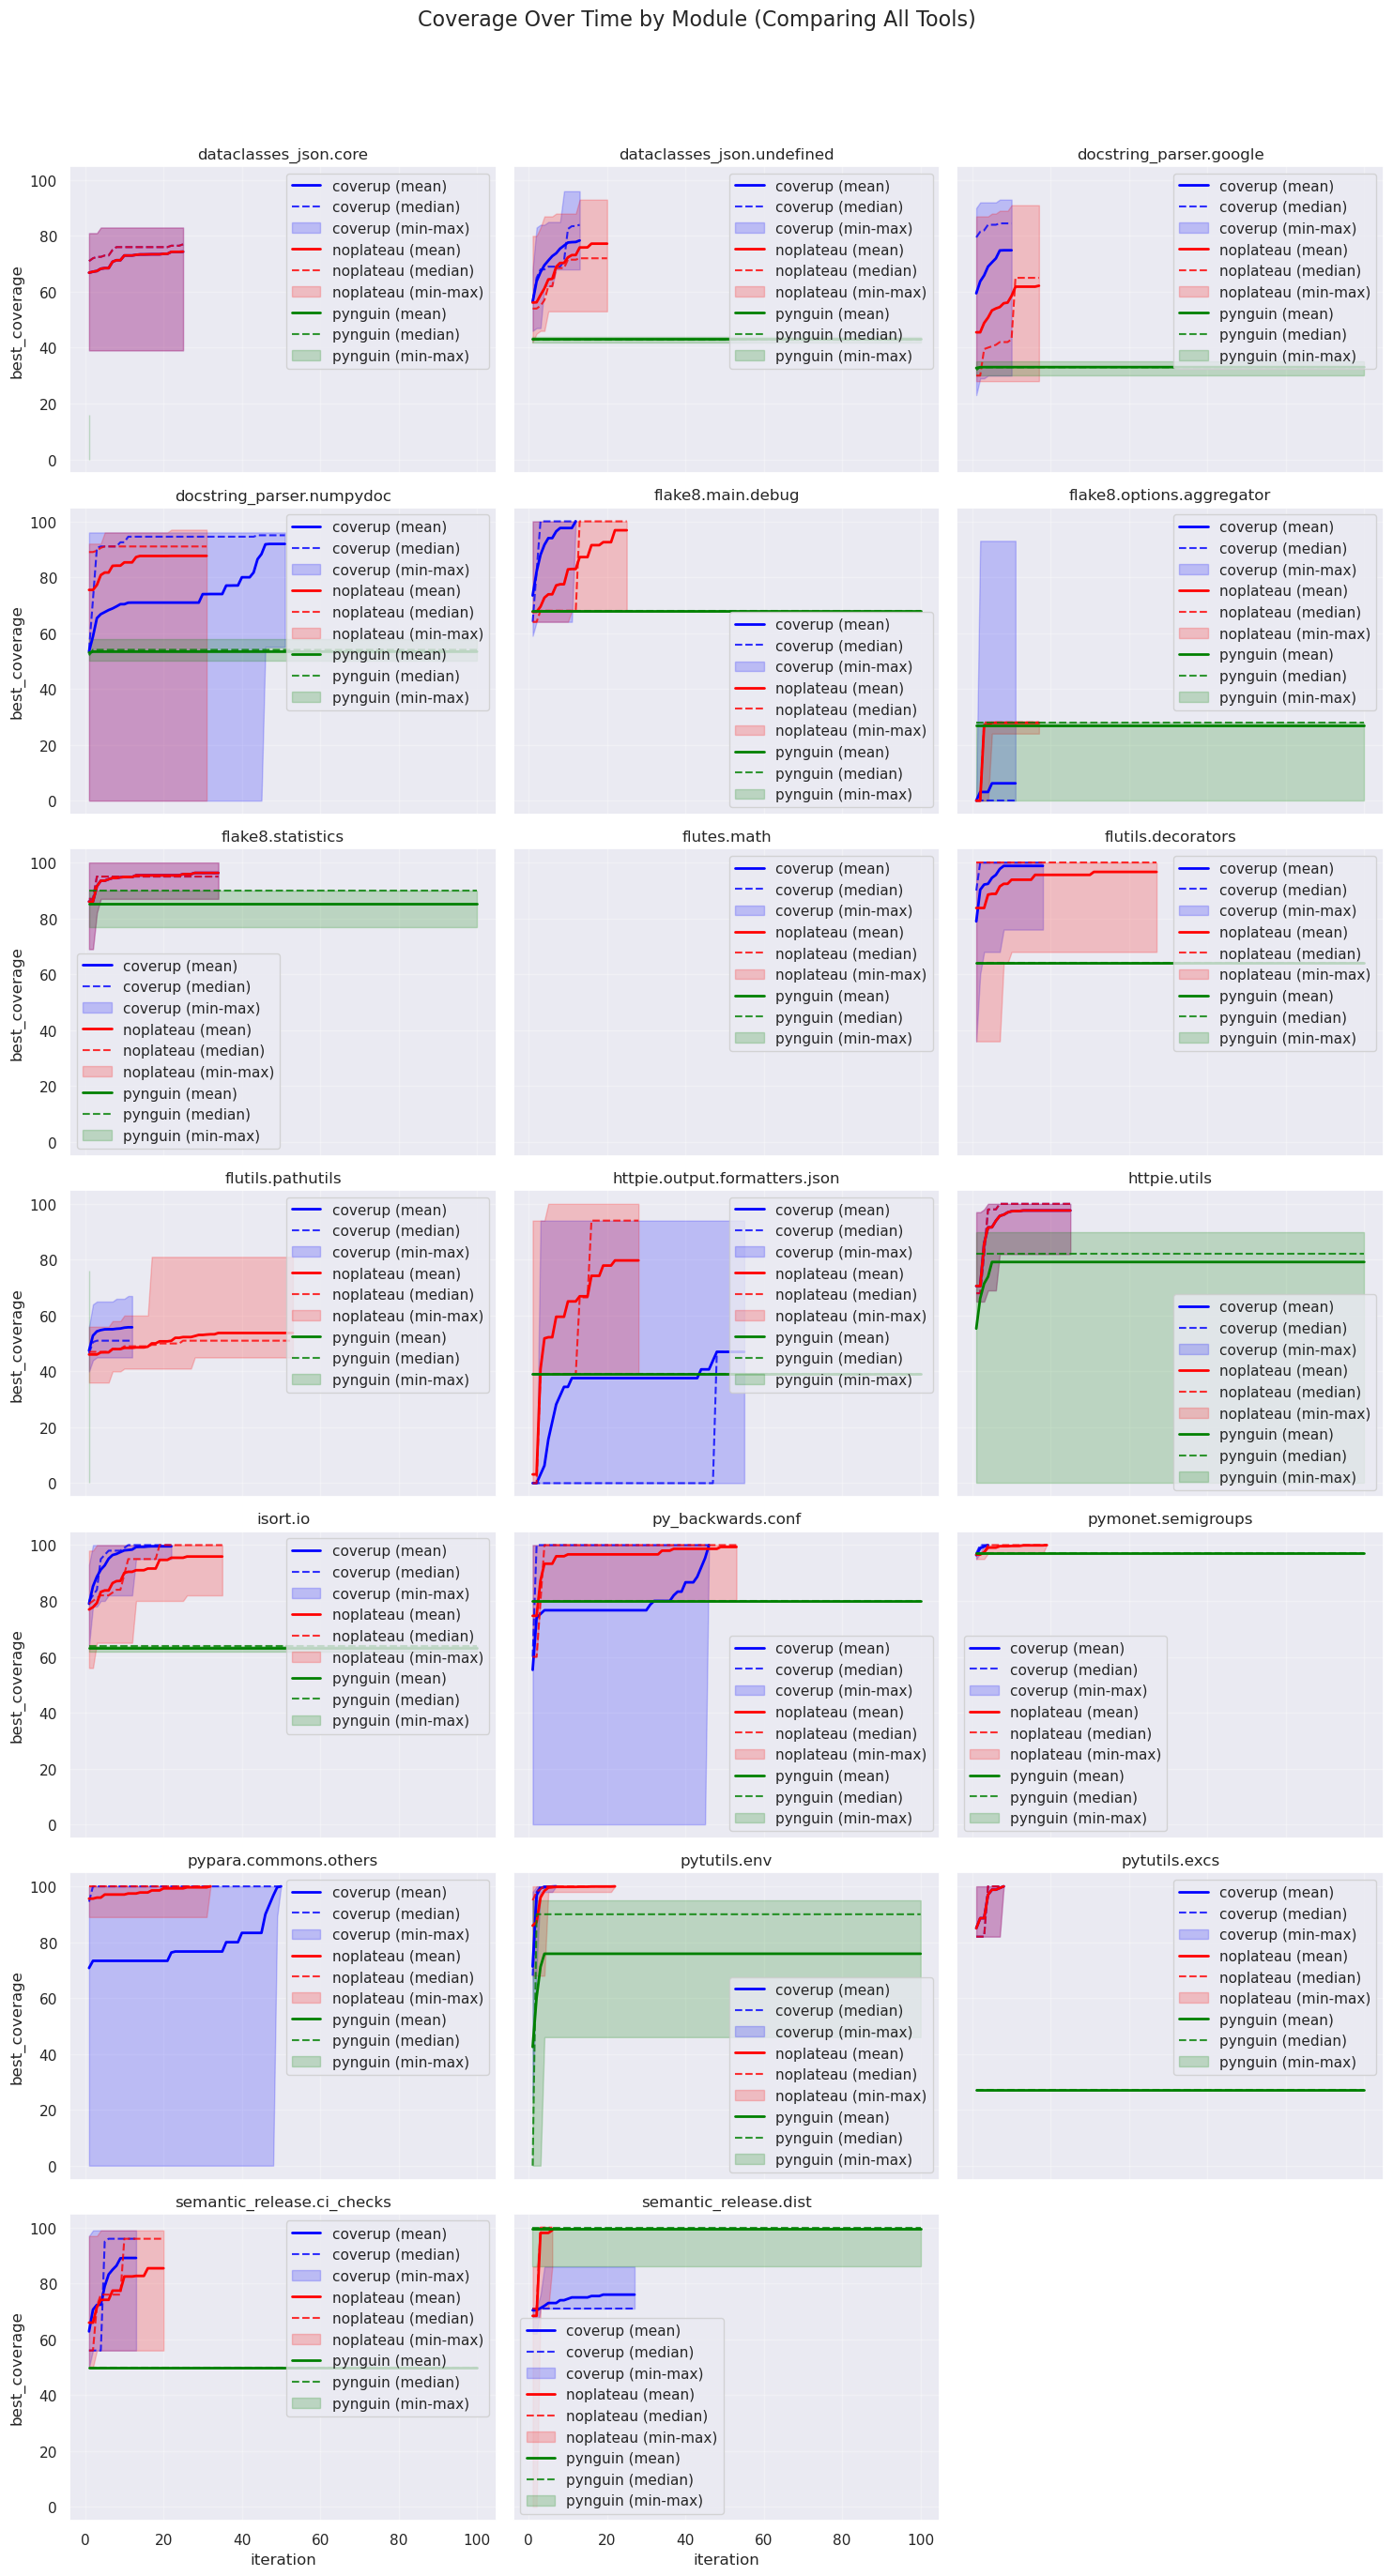

In [12]:
# Plot with the original grouped data (no extension needed)
n_modules = len(modules)
n_cols = min(3, n_modules)
n_rows = (n_modules + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4*n_rows), sharex=True, sharey=True)
axes = axes.flatten() if n_rows * n_cols > 1 else [axes]

for i, module in enumerate(modules):
    ax = axes[i]
    module_data = grouped[grouped['module'] == module].copy()
    
    # Convert columns to numeric for plotting
    module_data[time_column] = pd.to_numeric(module_data[time_column], errors='coerce')
    module_data['mean'] = pd.to_numeric(module_data['mean'], errors='coerce')
    module_data['median'] = pd.to_numeric(module_data['median'], errors='coerce')
    module_data['min'] = pd.to_numeric(module_data['min'], errors='coerce')
    module_data['max'] = pd.to_numeric(module_data['max'], errors='coerce')
    
    # Plot each tool separately
    for tool in tools:
        tool_data = module_data[module_data['tool'] == tool]
        if len(tool_data) > 0:
            color = tool_colors.get(tool, 'gray')
            
            # Plot mean line
            ax.plot(tool_data[time_column], tool_data['mean'], 
                    color=color, 
                    linewidth=2, 
                    label=f'{tool} (mean)',
                    linestyle='-')
            
            # Plot median line
            ax.plot(tool_data[time_column], tool_data['median'],
                    color=color,
                    linestyle='--',
                    linewidth=1.5,
                    label=f'{tool} (median)',
                    alpha=0.8)
            
            # Add shaded area for min-max range
            ax.fill_between(tool_data[time_column], 
                           tool_data['min'], 
                           tool_data['max'], 
                           color=color, 
                           alpha=0.2, 
                           label=f'{tool} (min-max)')
    
    ax.set_title(f'{module}')
    ax.grid(True, alpha=0.3)
    ax.legend()
    
    if i % n_cols == 0:
        ax.set_ylabel(coverage_column)
    if i >= (n_rows - 1) * n_cols:
        ax.set_xlabel(time_column)

# Hide unused subplots
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.suptitle('Coverage Over Time by Module (Comparing All Tools)', fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.92)

os.makedirs('figures', exist_ok=True)
plt.savefig('figures/coverage_over_time_by_module_all_tools.png', dpi=300, bbox_inches='tight')
plt.show()


## Analysis of Final Coverage by Experiment


/tmp/ipykernel_61805/3555200948.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=module_data, x='tool', y='best_coverage', ax=ax, palette=tool_colors)
/tmp/ipykernel_61805/3555200948.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=module_data, x='tool', y='best_coverage', ax=ax, palette=tool_colors)
/tmp/ipykernel_61805/3555200948.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=module_data, x='tool', y='best_coverage', ax=ax, palette=tool_colors)
/tmp/ipykernel_61805/3555200948.py:25: FutureWarning: 

Passing `pa

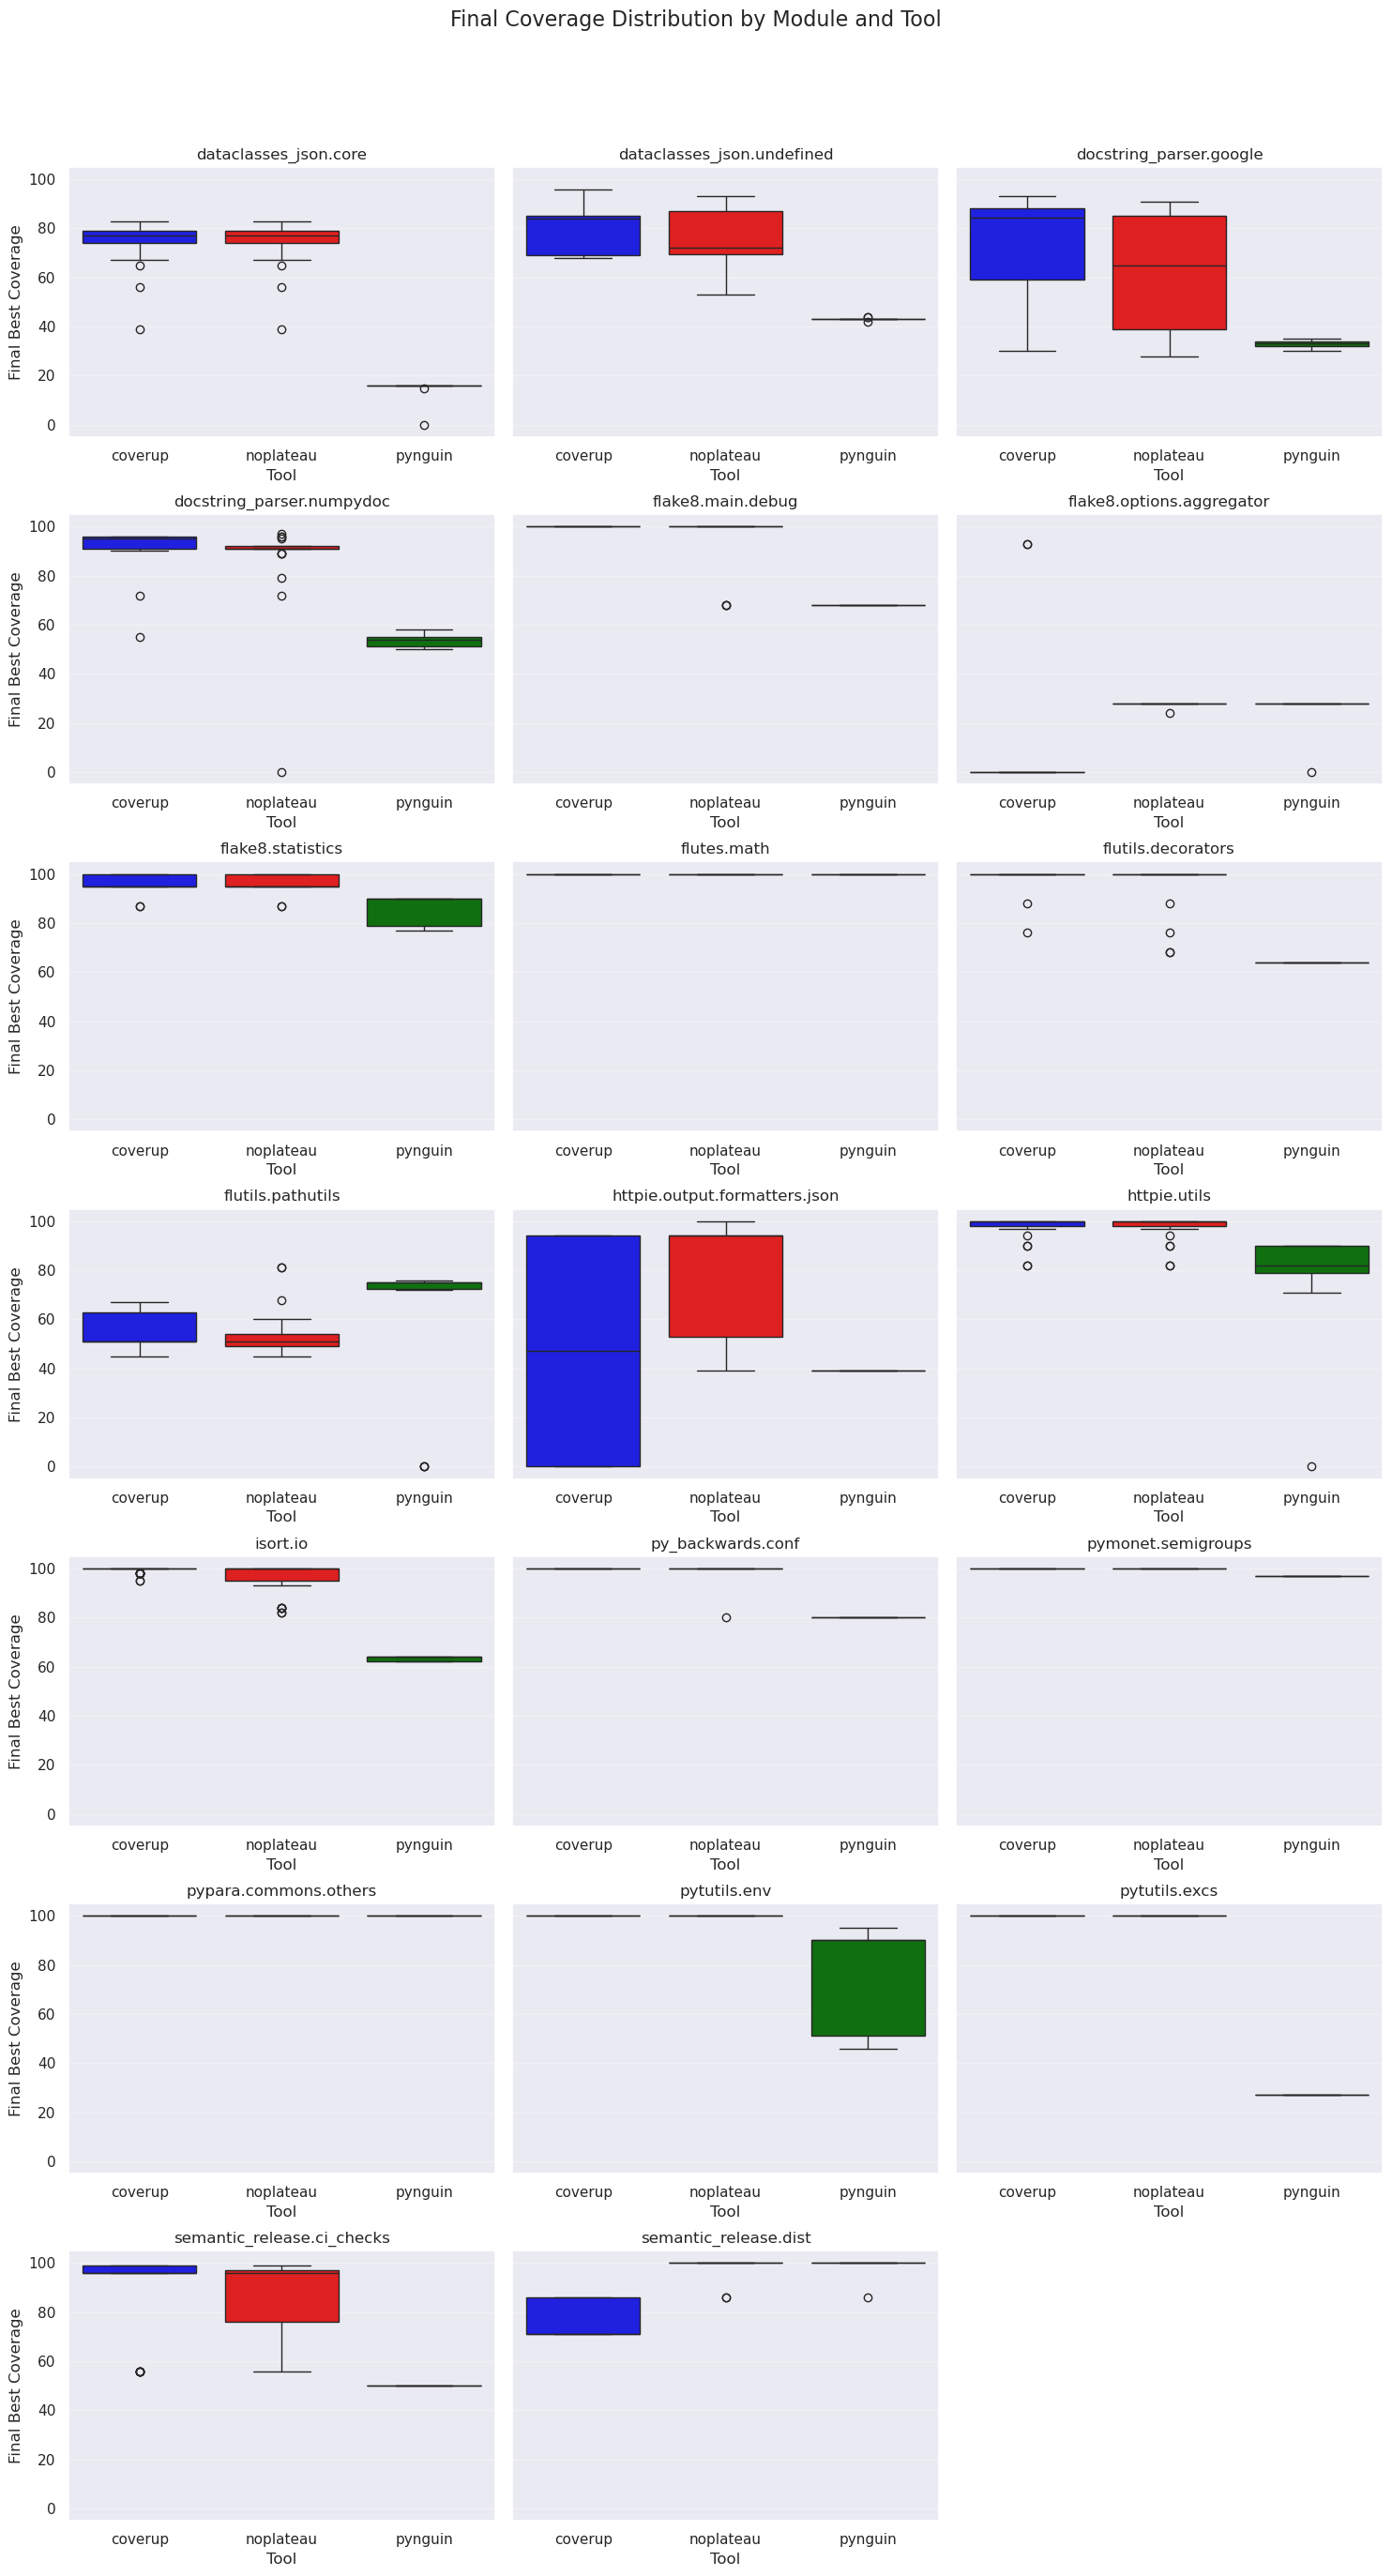

/tmp/ipykernel_61805/3555200948.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=final_coverage, x='tool', y='best_coverage', palette=tool_colors)


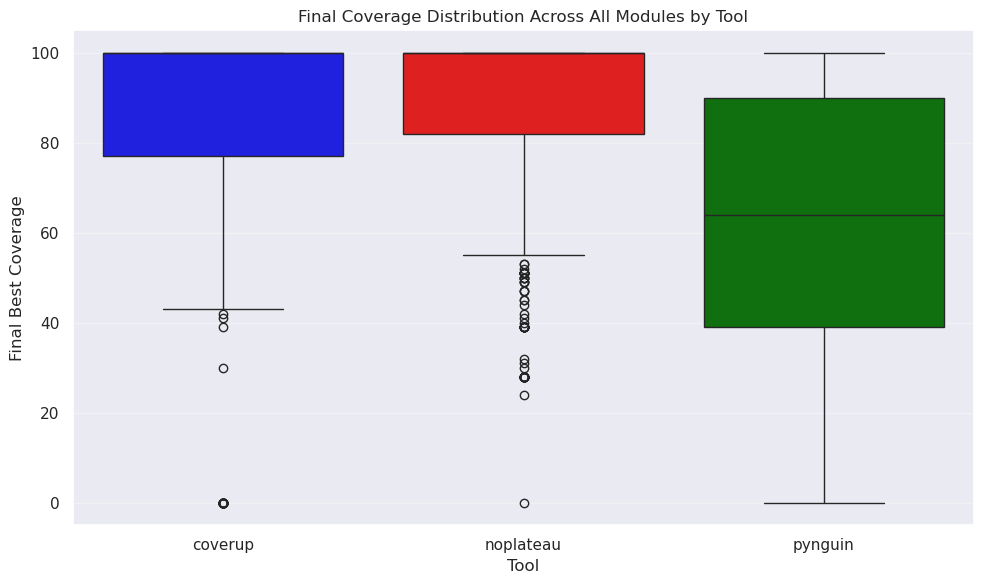

In [13]:
# Analyze the final coverage distribution by module as a boxplot

# For each run, get the final (max iteration) best_coverage
final_coverage = (
    combined_df
    .sort_values(['module', 'tool', 'module_run_num', 'iteration'])
    .groupby(['module', 'tool', 'module_run_num'])
    .tail(1)
)

# Create subplot for each module
modules = sorted(final_coverage['module'].unique())
n_modules = len(modules)
n_cols = min(3, n_modules)
n_rows = (n_modules + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4*n_rows), sharey=True)
axes = axes.flatten() if n_rows * n_cols > 1 else [axes]

for i, module in enumerate(modules):
    ax = axes[i]
    module_data = final_coverage[final_coverage['module'] == module]
    
    # Create boxplot for this module
    sns.boxplot(data=module_data, x='tool', y='best_coverage', ax=ax, palette=tool_colors)
    ax.set_title(f'{module}')
    ax.set_xlabel('Tool')
    ax.set_ylabel('Final Best Coverage')
    ax.grid(True, axis='y', alpha=0.3)

# Hide unused subplots
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.suptitle('Final Coverage Distribution by Module and Tool', fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.92)

plt.savefig('figures/final_coverage_distribution_all_tools.png', dpi=300, bbox_inches='tight')
plt.show()

# Overall comparison across all modules
plt.figure(figsize=(10, 6))
sns.boxplot(data=final_coverage, x='tool', y='best_coverage', palette=tool_colors)
plt.title('Final Coverage Distribution Across All Modules by Tool')
plt.xlabel('Tool')
plt.ylabel('Final Best Coverage')
plt.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('figures/final_coverage_overall_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

/tmp/ipykernel_61805/1595118796.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=final_coverage, x='tool', y='best_coverage', palette=tool_colors, inner='box')


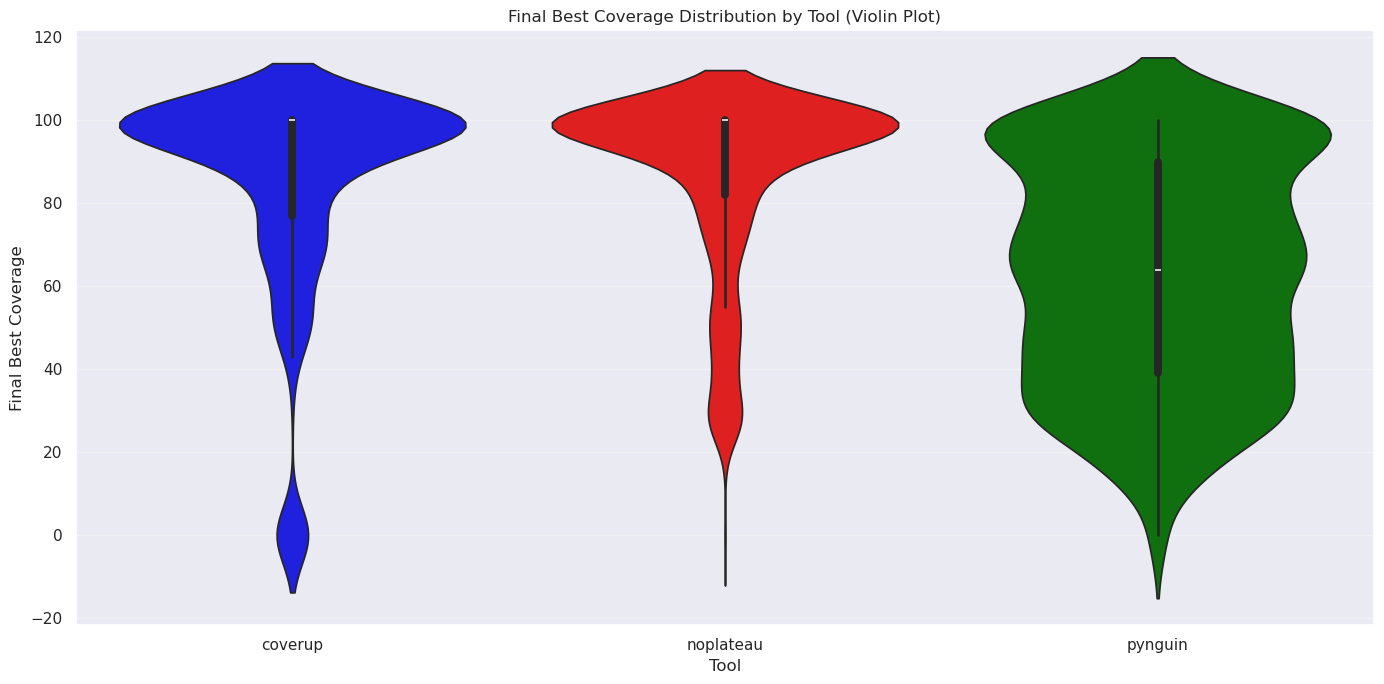

In [14]:
# Violin plot of final best coverage by tool for each module

plt.figure(figsize=(14, 7))
sns.violinplot(data=final_coverage, x='tool', y='best_coverage', palette=tool_colors, inner='box')
plt.title('Final Best Coverage Distribution by Tool (Violin Plot)')
plt.xlabel('Tool')
plt.ylabel('Final Best Coverage')
plt.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('figures/final_coverage_violin_by_tool.png', dpi=300, bbox_inches='tight')
plt.show()

/tmp/ipykernel_61805/1595118796.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=final_coverage, x='tool', y='best_coverage', palette=tool_colors, inner='box')


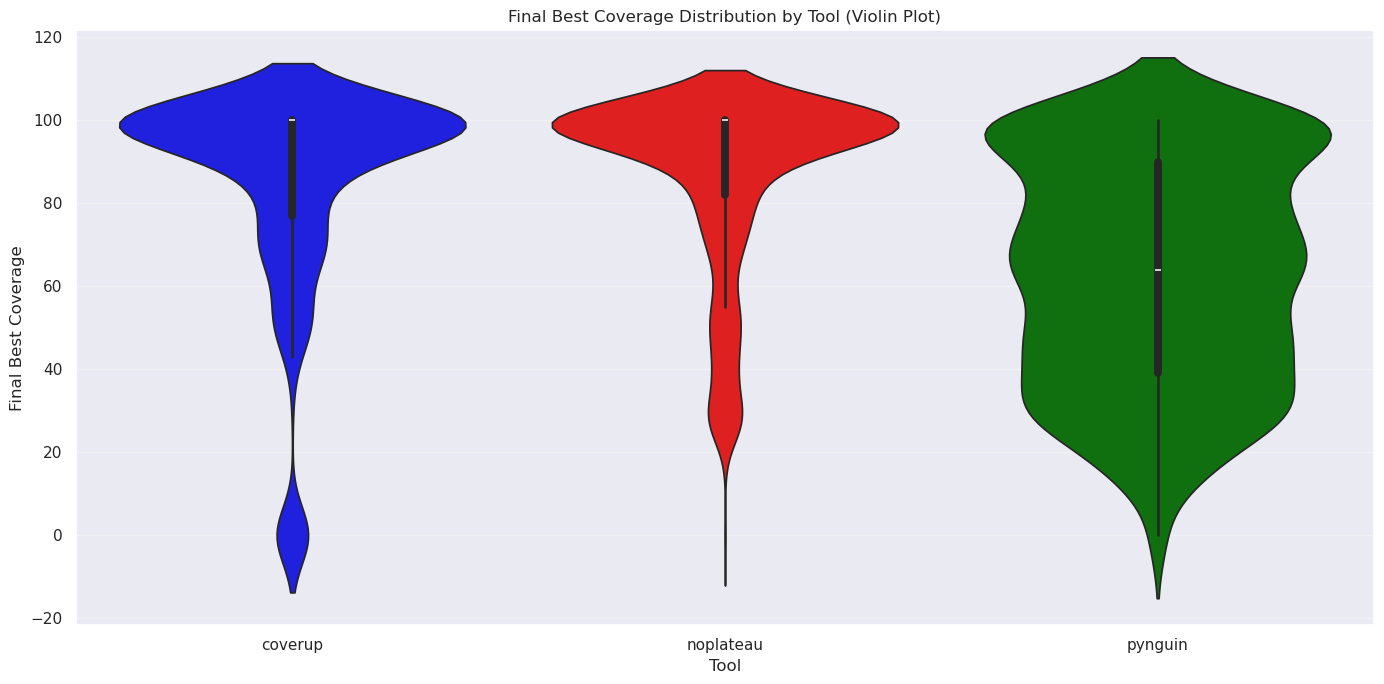

In [15]:
# Violin plot of final best coverage by tool for each module

plt.figure(figsize=(14, 7))
sns.violinplot(data=final_coverage, x='tool', y='best_coverage', palette=tool_colors, inner='box')
plt.title('Final Best Coverage Distribution by Tool (Violin Plot)')
plt.xlabel('Tool')
plt.ylabel('Final Best Coverage')
plt.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('figures/final_coverage_violin_by_tool.png', dpi=300, bbox_inches='tight')
plt.show()

In [16]:
# Calculate the percentage of runs with final best_coverage below the tail for each tool
tail = 30

# Ensure best_coverage is numeric
final_coverage['best_coverage'] = pd.to_numeric(final_coverage['best_coverage'], errors='coerce')

percent_below_tail = (
    final_coverage.groupby('tool')
    .apply(lambda df: (df['best_coverage'] < tail).mean() * 100)
    .rename('percent_below_tail')
    .reset_index()
)

print("Tail cutoff:", tail)
print(percent_below_tail)



Tail cutoff: 30
        tool  percent_below_tail
0    coverup            5.740988
1  noplateau            5.342237
2    pynguin           15.771812


/tmp/ipykernel_61805/3653589720.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda df: (df['best_coverage'] < tail).mean() * 100)


In [17]:
# Check the percentage of modules that have below 30% final coverage in both coverup and noplateau 
coverup_modules = final_coverage[final_coverage['tool'] == 'coverup']
noplateau_modules = final_coverage[final_coverage['tool'] == 'noplateau']
coverup_below_30 = coverup_modules[coverup_modules['best_coverage'] < 30]['module'].unique()
noplateau_below_30 = noplateau_modules[noplateau_modules['best_coverage'] < 30]['module'].unique()
common_below_30 = set(coverup_below_30) & set(noplateau_below_30)
print(f"Modules with below 30% final coverage in both coverup and noplateau: {len(common_below_30)}")
print("Common modules:", common_below_30)

Modules with below 30% final coverage in both coverup and noplateau: 1
Common modules: {'flake8.options.aggregator'}


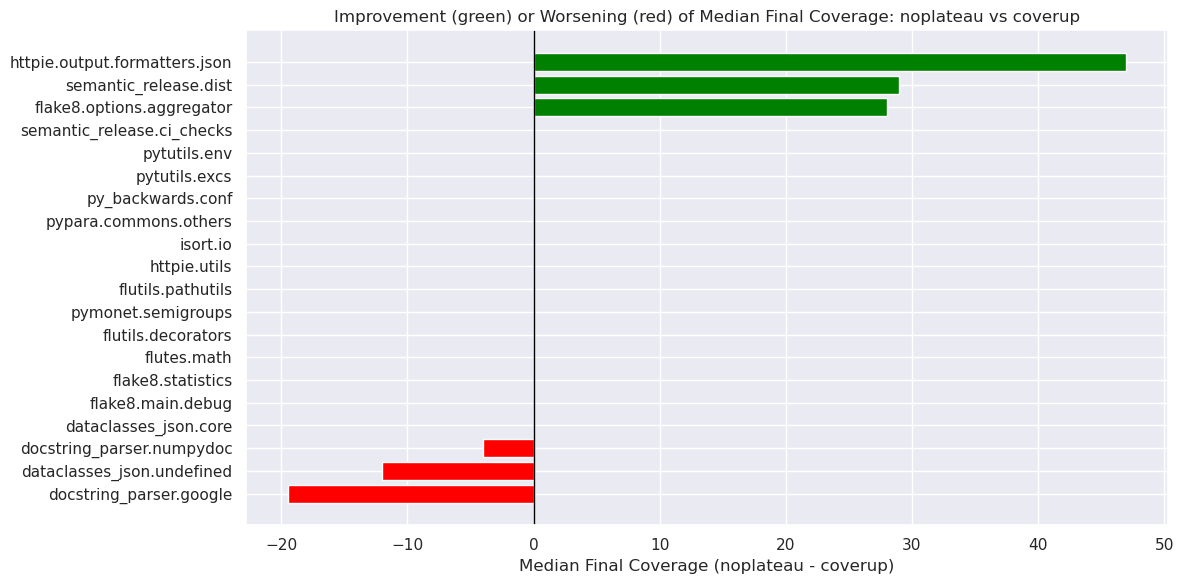

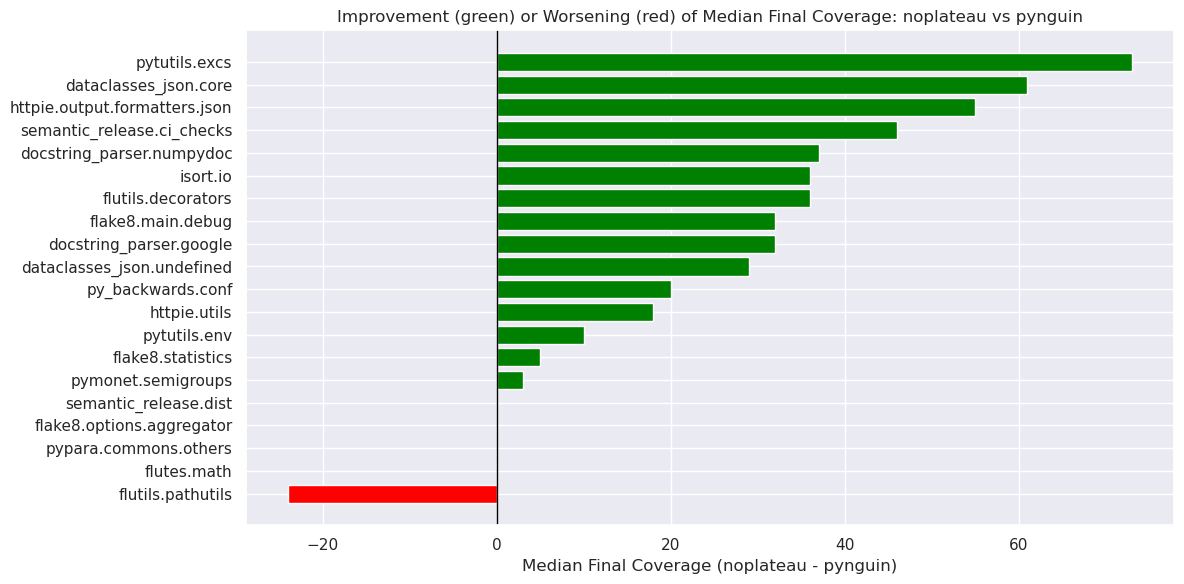

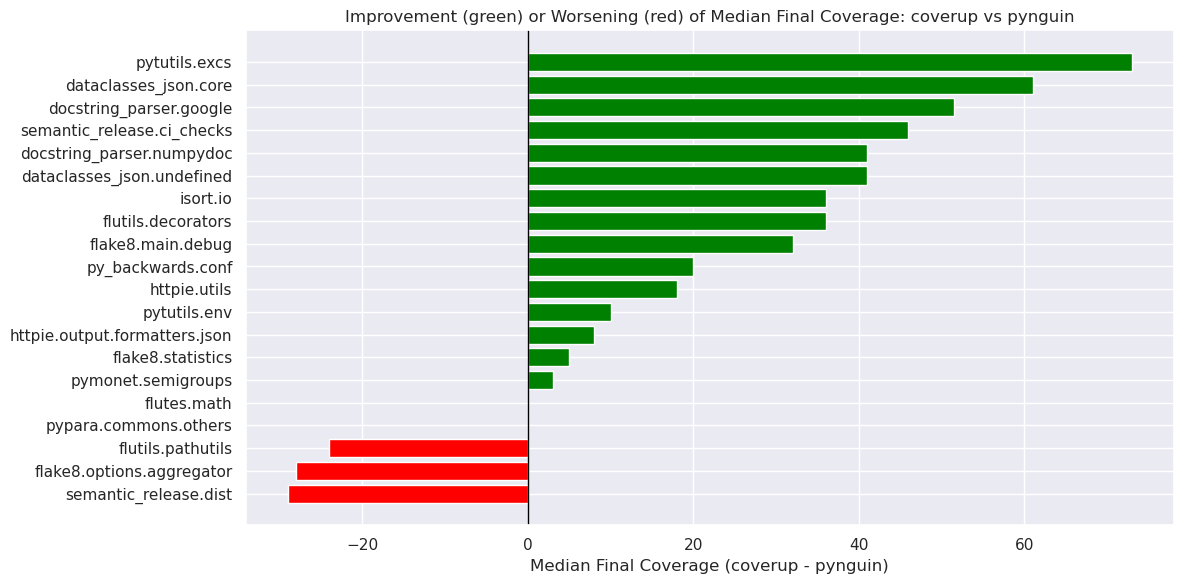

In [ ]:
def plot_median_final_coverage_diff(tool_b, tool_a):
    """
    Plot the difference in median final best_coverage between two tools for each module.
    """
    median_final_coverage = (
        final_coverage[final_coverage['tool'].isin([tool_a, tool_b])]
        .groupby(['module', 'tool'])['best_coverage']
        .median()
        .unstack()
    )

    # Compute the difference: tool_b - tool_a
    median_final_coverage['diff'] = median_final_coverage[tool_b] - median_final_coverage[tool_a]

    # Sort modules by difference for better visualization
    median_final_coverage_sorted = median_final_coverage.sort_values('diff')

    # Plot the difference as a bar plot
    plt.figure(figsize=(12, 6))
    bars = plt.barh(
        median_final_coverage_sorted.index,
        median_final_coverage_sorted['diff'],
        color=np.where(median_final_coverage_sorted['diff'] >= 0, 'green', 'red')
    )
    plt.axvline(0, color='black', linewidth=1)
    plt.xlabel(f'Median Final Coverage ({tool_b} - {tool_a})')
    plt.title(f'Improvement (green) or Worsening (red) of Median Final Coverage: {tool_b} vs {tool_a}')
    plt.tight_layout()
    plt.show()


plot_median_final_coverage_diff('noplateau', 'coverup')
plot_median_final_coverage_diff('noplateau', 'pynguin')
plot_median_final_coverage_diff('coverup', 'pynguin')